# How betweeness is correlated with energies of nodes?

In this experiment we are considering the measure of energy dispersion and its correlation to betweeness structural measure of nodes. There are multiple graph energies proposed in the literature, but our primary interest lies in Randić energy.

Within the experiment we calculate graph energy fo each node by means of their ego-network. Then we compare how betweenes of nodes is correlated with their ego-net graph enery.


### graph energy

Graph energy of a graph is defined as $E_G(G) = \sum\limits_{i=1}^n |\mu_i|$, where $\mu_1, \ldots, \mu_n$ are the eigenvalues of the adjacency matrix $M_A$ (also known as the *spectrum* of the graph).

### Randić energy

Randić matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_R(i,j)=
\begin{cases}
0 & \mathit{if} & i=j\\
\frac{1}{\sqrt{d_i d_j}} & \mathit{if} & (i,j) \in E\\
0 & \mathit{if} & (i,j) \notin E
\end{cases}
$$

Randić energy of a graph is defined as $E_R(G) = \sum\limits_{i=1}^n |\rho_i|$, where $\rho_1, \ldots, \rho_n$ are the eigenvalues of the Randić matrix $M_R$.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm
from ggplot import *

import pandas as pd
import numpy as np
import networkx as nx
import scipy, scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

from networkentropy import network_energy as ne
import time

from multiprocessing import Pool
import time
import itertools

import matplotlib.pyplot as plt
import networkx as nx

In [3]:
def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def _betmap(G_normalized_weight_sources_tuple):
    """Pool for multiprocess only accepts functions with one argument.
    This function uses a tuple as its only argument. We use a named tuple for
    python 3 compatibility, and then unpack it when we send it to
    `betweenness_centrality_source`
    """
    return nx.betweenness_centrality_source(*G_normalized_weight_sources_tuple)


def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.map(_betmap,
                  zip([G] * num_chunks,
                      [True] * num_chunks,
                      [None] * num_chunks,
                      node_chunks))

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
            
    p.close()
    return bt_c

def calculate_betweenes(graph, k):
    return nx.betweenness_centrality(graph, k=k)

def calculate_randic_energy(graph):
    results={}
    for n in graph.nodes:
        g = nx.ego_graph(G=graph, n=n, radius=1)
        results[n]=ne.get_randic_energy(g)
    return results

def calculate_graph_energy(graph):
    time_evaluation={}
    time_evaluation['ego']=0
    time_evaluation['graph_energy']=0
     
    results={}
    for n in graph.nodes:
        start = time.clock()
        g = nx.ego_graph(G=graph, n=n, radius=1)
        time_evaluation['ego']=time_evaluation['ego']+(time.clock() - start)
        start = time.clock()
        results[n]=ne.get_graph_energy(g)
        time_evaluation['graph_energy']=time_evaluation['graph_energy']+(time.clock() - start)
    return results, time_evaluation

def calculate_graph_energy_numpy(graph):
    results={}
    for n in graph.nodes:
        g = nx.ego_graph(G=graph, n=n, radius=1)
        results[n]=get_graph_energy_numpy(g)
    return results

def get_graph_energy_numpy(G):
    M = nx.adjacency_matrix(G).todense()
    graph_energy = np.abs(np.linalg.eigvals(M).real).sum()
    return graph_energy

def normalize_df_column(df_column):
    x = df_column.values.astype(float)
    min_max_scaler = skl.preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
    return x_scaled

### Frist experiment: synthetic data and graph energy and graph energy
wyliczenie dla wszystkich wierzchołków sieci ich pośrednictwa, pośrednictwa szacowanego na podstawie ścieżek o długości 2, 3, ..., k, oraz energii macierzy sąsiedztwa w sieci egocentrycznej

In [67]:
num_nodes=20
betweenness_parameter_samples=1

results=pd.DataFrame(columns=['node', 'value_type', 'value_param','value','network', 'network_param'])

for p in tqdm(range(1,100)):

    generators = {
        'random': nx.erdos_renyi_graph(n=num_nodes, p=p/100.0),
        'smallworld': nx.watts_strogatz_graph(n=num_nodes, k=4, p=p/100.0),
        'waxman': nx.waxman_graph(n=num_nodes, alpha=p/100.0, beta=0.1),
        'powerlaw': nx.powerlaw_cluster_graph(n=num_nodes, m=3, p=p/1000.0)
    }
    
    for generator in generators.keys():
        
        G = generators[generator]

        bet={}
        for k in range(2,num_nodes,int(num_nodes/betweenness_parameter_samples)):
            bb=calculate_betweenes(G,k=k)
            
            tmp_df=pd.DataFrame({'node': [i[0] for i in bb.items()],
                                 'value_type': ['betweenness' for i in bb.items()],
                                 'value_param': [k for i in bb.items()],
                                 'value': [i[1] for i in bb.items()],
                                 'network': [generator for i in bb.items()],
                                 'network_param': [p for i in bb.items()]
                                })
            tmp_df['value']=normalize_df_column(tmp_df['value'])
            results=pd.concat([results,tmp_df])
        
        be=calculate_betweenes(G,k=None)
        tmp_df=pd.DataFrame({'node': [i[0] for i in be.items()],
                             'value_type': ['betweenness' for i in be.items()],
                             'value_param': [None for i in be.items()],
                             'value': [i[1] for i in be.items()],
                             'network': [generator for i in be.items()],
                             'network_param': [p for i in be.items()]
                            })
        tmp_df['value']=normalize_df_column(tmp_df['value'])
        results=pd.concat([results,tmp_df])
        
        
        re=calculate_randic_energy(G)
        tmp_df=pd.DataFrame({'node': [i[0] for i in re.items()],
                             'value_type': ['randic' for i in re.items()],
                             'value_param': [None for i in re.items()],
                             'value': [i[1] for i in re.items()],
                             'network': [generator for i in re.items()],
                             'network_param': [p for i in re.items()]
                            })
        tmp_df['value']=normalize_df_column(tmp_df['value'])
        results=pd.concat([results,tmp_df])
        
        ge,_=calculate_graph_energy(G)
        tmp_df=pd.DataFrame({'node': [i[0] for i in ge.items()],
                             'value_type': ['graph' for i in ge.items()],
                             'value_param': [None for i in ge.items()],
                             'value': [i[1] for i in ge.items()],
                             'network': [generator for i in ge.items()],
                             'network_param': [p for i in ge.items()]
                            })
        tmp_df['value']=normalize_df_column(tmp_df['value'])
        results=pd.concat([results,tmp_df])
        
results.to_pickle('./calulated_betweenness_and_energy.pickle')     

100%|██████████| 99/99 [00:17<00:00,  5.65it/s]


- wyznaczenie prostej regresji liniowej m/y pośrednictwem i energią wierzchołka, miarami jakości mogą być:
  * korelacja Pearsona
  * korelacja Spearmana
  * korelacja Kendalla
  * błąd bezwzględny (po normalizacji obu miar)
  * błąd średniokwadratowy (po normalizacji obu miar)

In [312]:
l_model=skl.linear_model.LinearRegression()
prediction_results=pd.DataFrame(columns=['network', 'network_param', 'error_type', 'error_value'])

for net in tqdm(results['network'].unique()):
    for net_param in results[results['network']==net]['network_param'].unique():
        y=results[(results['network']==net) & 
                  (results['network_param']==net_param) & 
                  (results['value_type']=='betweenness') & 
                  (results['value_param'].isnull())
                 ]['value'].values
#         print(X)
        X=results[(results['network']==net) & 
                  (results['network_param']==net_param) & 
                  (results['value_type']=='graph')
                 ]['value'].values
#         print('y',y)
        l_model.fit(X=X.reshape(-1, 1), y=y)
        y_pred=l_model.predict(X.reshape(-1, 1))
        
        
        mae=skl.metrics.mean_absolute_error(y_true=y, y_pred=y_pred)
        tmp_df=pd.DataFrame({'network': [net],
                             'network_param': [net_param],
                             'error_type': ['MAE'], 
                             'error_value': [mae]
                            })
        prediction_results=pd.concat([prediction_results,tmp_df])
        
        mse=skl.metrics.mean_squared_error(y_true=y, y_pred=y_pred)
        tmp_df=pd.DataFrame({'network': [net],
                             'network_param': [net_param],
                             'error_type': ['MSE'], 
                             'error_value': [mse]
                            })
        prediction_results=pd.concat([prediction_results,tmp_df])
        
        pearson,_=scipy.stats.pearsonr(y,y_pred)
        tmp_df=pd.DataFrame({'network': [net],
                             'network_param': [net_param],
                             'error_type': ['pearson'], 
                             'error_value': [pearson]
                            })
        prediction_results=pd.concat([prediction_results,tmp_df])
        
        spearman,_=scipy.stats.spearmanr(y,y_pred, axis=0, nan_policy='propagate')
        tmp_df=pd.DataFrame({'network': [net],
                             'network_param': [net_param],
                             'error_type': ['spearman'], 
                             'error_value': [spearman]
                            })
        prediction_results=pd.concat([prediction_results,tmp_df])
        
        
        y_ranked=scipy.stats.rankdata(y, method='ordinal') #może metoda average
        y_pred_ranked=scipy.stats.rankdata(y_pred, method='ordinal')
        
        kendall,_=scipy.stats.kendalltau(y_ranked,y_pred_ranked, initial_lexsort=None, nan_policy='propagate')
        tmp_df=pd.DataFrame({'network': [net],
                             'network_param': [net_param],
                             'error_type': ['kendall'], 
                             'error_value': [kendall]
                            })
        prediction_results=pd.concat([prediction_results,tmp_df])
        
prediction_results.to_pickle('./prediction_results_errors.pickle')       

100%|██████████| 4/4 [00:08<00:00,  2.25s/it]


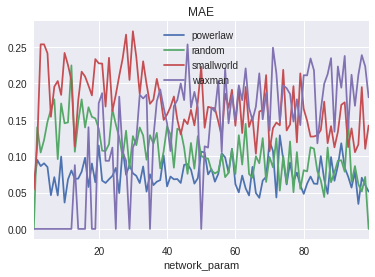

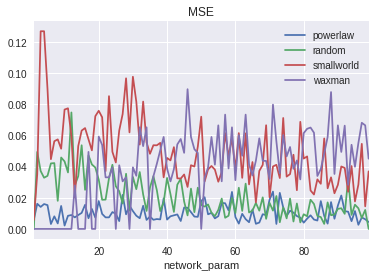

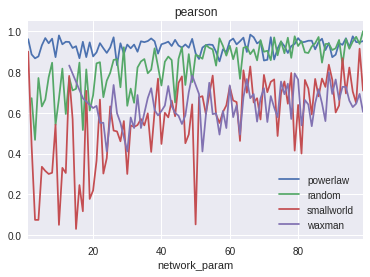

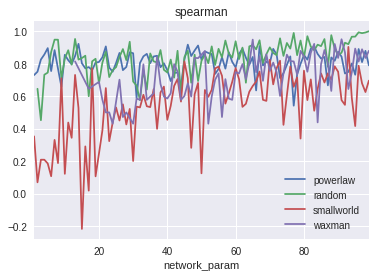

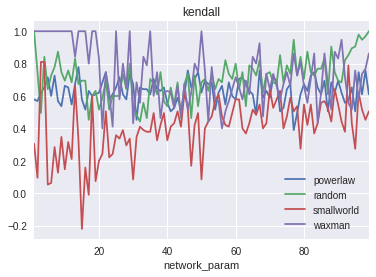

In [313]:


for et in prediction_results['error_type'].unique():
    fig, ax = plt.subplots()
    for key, grp in prediction_results[prediction_results['error_type']==et].dropna().groupby(['network']):
        ax = grp.plot(ax=ax, kind='line', x='network_param', y='error_value', label=key)
    
    plt.title(et)
    plt.legend(loc='best')
    plt.show()



# prediction_results[prediction_results['error_type']=="spearman"]['error_value'].hist()

In [310]:
prediction_results[prediction_results['error_type']=='MSE'].dropna()

,error_type,error_value,network,network_param
0,MSE,0.160000,random,1.0
0,MSE,0.077778,random,2.0
0,MSE,0.102632,random,3.0
0,MSE,0.054515,random,4.0
0,MSE,0.059086,random,5.0
0,MSE,0.077380,random,6.0
0,MSE,0.048945,random,7.0
0,MSE,0.015313,random,8.0
0,MSE,0.043623,random,9.0
0,MSE,0.042767,random,10.0


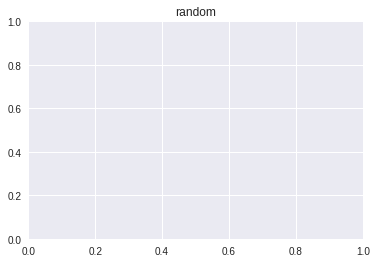

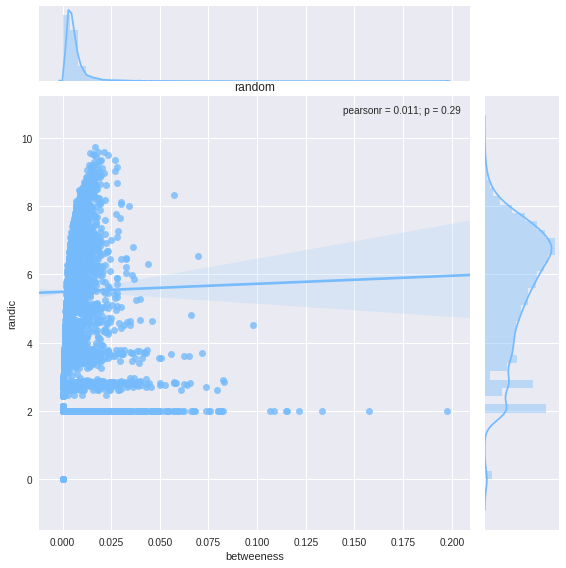

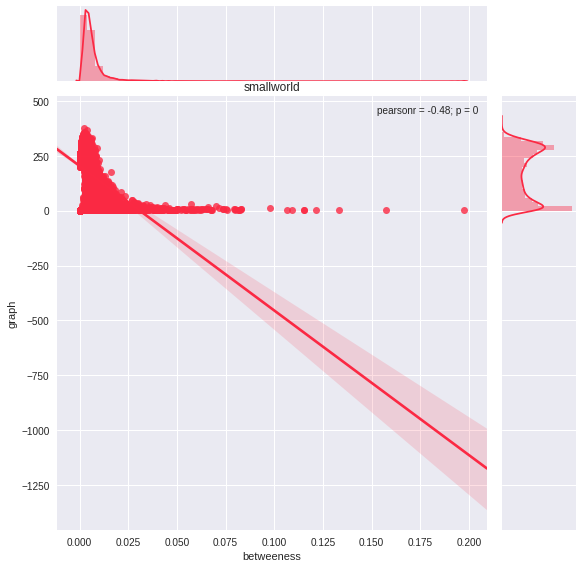

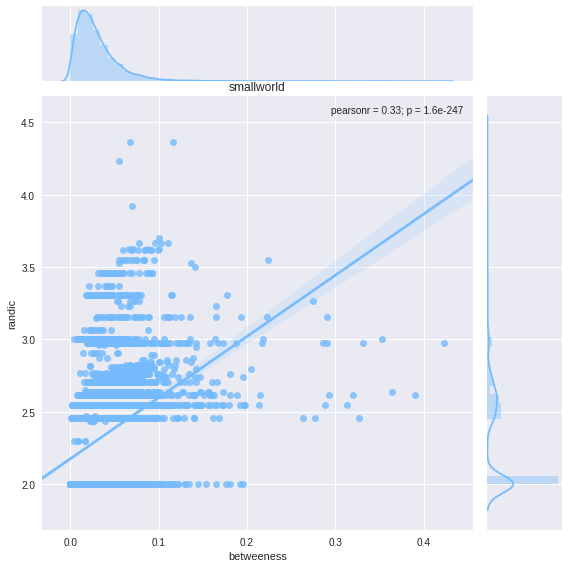

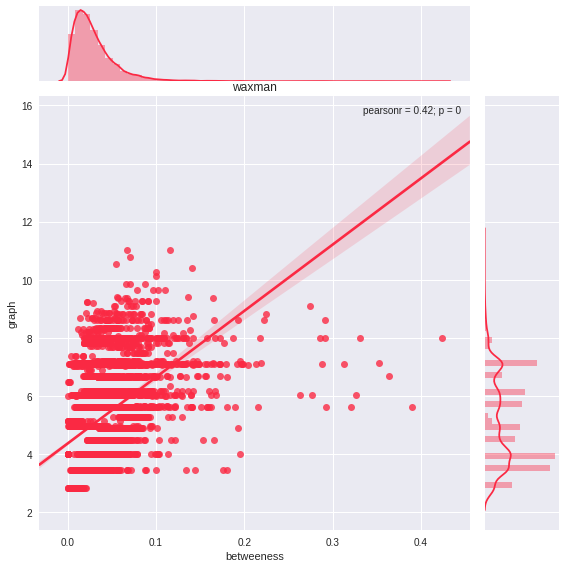

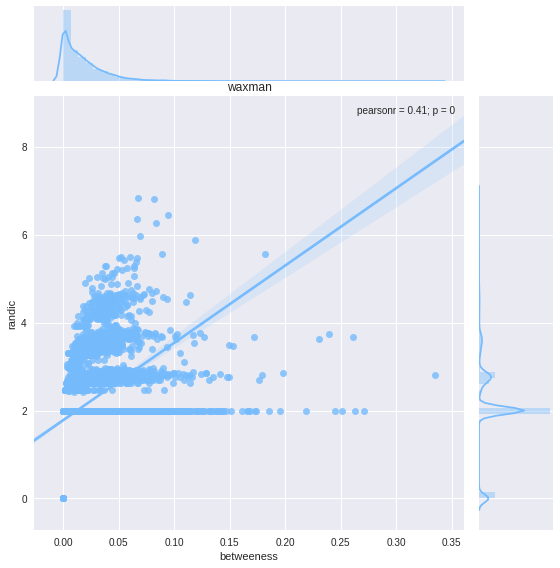

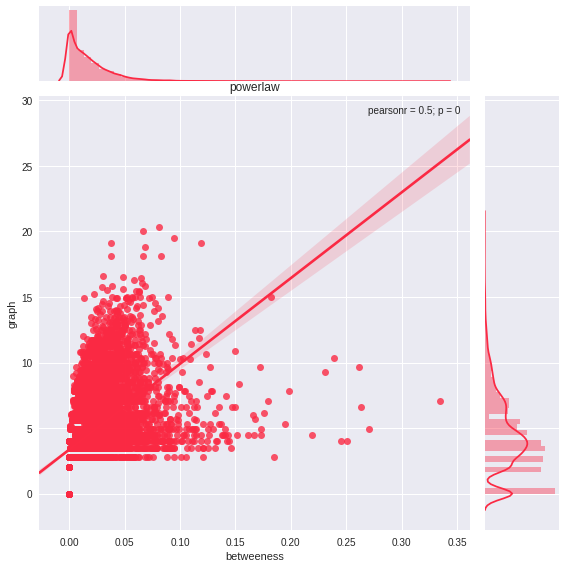

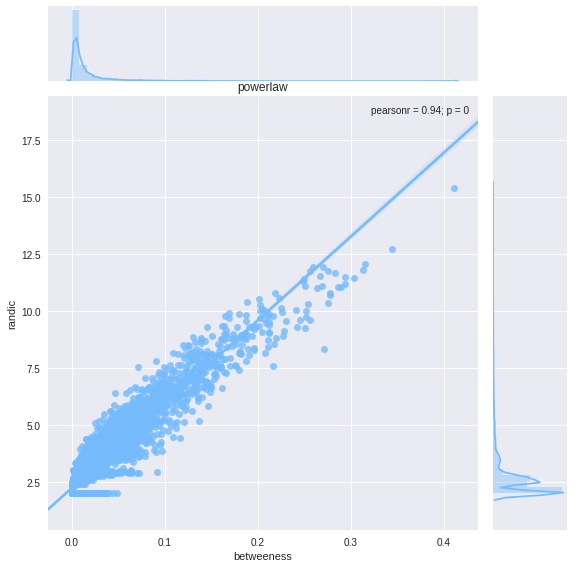

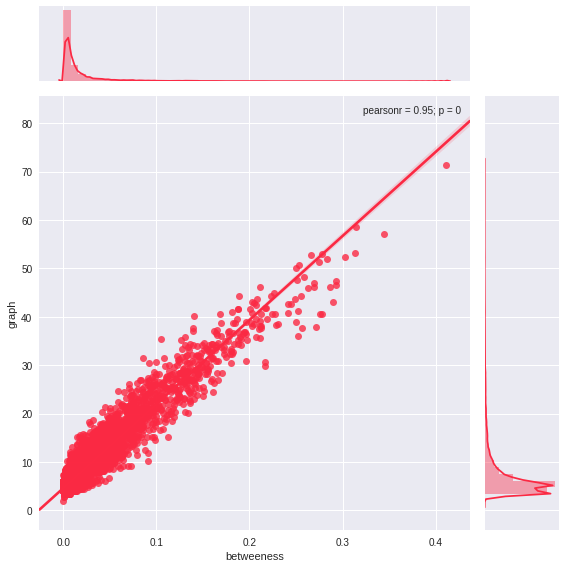

In [33]:
for network in results.network.unique():
    sns.plt.title(network)
    sns.jointplot("betweeness", "randic", data=results[results['network']==network], kind="reg", color="xkcd:sky blue", size=8)
    
    sns.plt.title(network)
    sns.jointplot("betweeness", "graph", data=results[results['network']==network], kind="reg", color="xkcd:strawberry", size=8)

#### Summary: 
- only in power law networks we can observe high correlations ($\rho=0.94$) between Randić energy of ego networks and betweeness

### Second experiment: real-word data

In [68]:
from bs4 import BeautifulSoup
import requests
import wget
import tarfile
import os
import shutil
import time

In [69]:
def read_avalilable_datasets_konect():
    base_url = "http://konect.uni-koblenz.de/downloads/"
#     print(base_url)
    response = requests.get(base_url)
    
    if response.status_code != 200:
        print("An error occurred while getting data.")
    else:
        html = response.content
        soup = BeautifulSoup(html, "html5lib")
        
        table_html = soup.find(id='sort1')
        
        thead_html = table_html.find('thead')
        tbody_html = table_html.find('tbody')
         
        column_names=[row.text for row in thead_html.findAll('td')]
        rows = tbody_html.findAll('tr')
        values=[[cell.get('href') for cell in value('a') if 'tsv' in cell.get('href')] for value in rows]
        return [val[0].replace('.tar.bz2','').replace('tsv/','') for val in values]
        
def download_tsv_dataset_konect(network_name):
    assert (network_name in read_avalilable_datasets_konect()),"No network named: '"+network_name+"' found in Konect!"
    
    tsv_file = 'http://konect.uni-koblenz.de/downloads/tsv/'+network_name+'.tar.bz2'
    output_file=network_name+'.tar.bz2'
    file_name = wget.download(tsv_file, out=output_file)
    if os.path.exists(output_file):
        shutil.move(file_name,output_file)
    
    return output_file
    
def unpack_tar_bz2_file(file_name):
    tar = tarfile.open("./"+file_name, "r:bz2")
    output_dir="./network_"+file_name.replace('.tar.bz2','')+"/"
    tar.extractall(output_dir)
    tar.close()
    return output_dir

def build_network_from_out_konect(network_name):
    file_name=download_tsv_dataset_konect(network_name=network_name)
    output_dir=unpack_tar_bz2_file(file_name)+network_name+"/"
    files = [file for file in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, file))]
    out_file = [file for file in files if 'out.' in file]
    assert (len(out_file)>0), 'No out. file in the directory.'
    
    #building network
    G=nx.read_adjlist(output_dir+out_file[0], comments='%')
    
    return G

In [82]:
networks_names=['moreno_beach',
 'moreno_bison',
 'moreno_blogs',
 'moreno_cattle',
 'moreno_crime',
 'moreno_health',
#  'moreno_hens',
 'moreno_highschool',
 'moreno_innovation',
 'moreno_kangaroo',
 'moreno_lesmis',
 'moreno_mac',
 'moreno_names',
 'moreno_oz',
 'moreno_propro',
 'moreno_rhesus',
 'moreno_sampson',
 'moreno_seventh',
 'moreno_sheep',
 'moreno_taro',
 'moreno_train',
 'moreno_vdb',
 'moreno_zebra',
#  'brunson_club-membership',
#  'brunson_southern-women',
#  'brunson_corporate-leadership',
#  'brunson_revolution',
#  'brunson_south-africa',
#  'ucidata-gama',
#  'ucidata-zachary',
#  'opsahl-collaboration',
#  'opsahl-openflights',
#  'opsahl-powergrid',
#  'opsahl-southernwomen',
#  'opsahl-ucforum',
#  'opsahl-ucsocial',
#  'opsahl-usairport',
#  'contiguous-usa',
#  'dolphins',
#  'adjnoun_adjacency',
#  'mit',
#  'foodweb-baydry',
#  'foodweb-baywet',
#  'sociopatterns-hypertext',
#  'sociopatterns-infectious',
#  'radoslaw_email'
               ]

In [83]:
networks=[]
for network_name in tqdm(networks_names):
    networks.append(build_network_from_out_konect(network_name))

100%|██████████| 22/22 [00:42<00:00,  1.94s/it]


### Third experiment - checking the linear approximation of betweenness with entropies in real world networks

Firstly we calculate betweenness and energy measures for each node.

In [84]:
real_data_measures=pd.DataFrame(columns=['node', 'value_type','value','network'])

for i in tqdm(range(len(networks))):
    G = networks[i]
    
    be=calculate_betweenes(G,k=None)
    tmp_df=pd.DataFrame({'node': [i[0] for i in be.items()],
                         'value_type': ['betweenness' for i in be.items()],
                         'value': [i[1] for i in be.items()],
                         'network': [networks_names[i] for j in be.items()]
                        })
    tmp_df['value']=normalize_df_column(tmp_df['value'])
    real_data_measures=pd.concat([real_data_measures,tmp_df])
        
        
    re=calculate_randic_energy(G)
    tmp_df=pd.DataFrame({'node': [i[0] for i in re.items()],
                         'value_type': ['randic' for i in re.items()],
                         'value': [i[1] for i in re.items()],
                         'network': [networks_names[i] for j in be.items()]
                        })
    tmp_df['value']=normalize_df_column(tmp_df['value'])
    real_data_measures=pd.concat([real_data_measures,tmp_df])

    ge,_=calculate_graph_energy(G)
    tmp_df=pd.DataFrame({'node': [i[0] for i in ge.items()],
                         'value_type': ['graph' for i in ge.items()],
                         'value': [i[1] for i in ge.items()],
                         'network': [networks_names[i] for j in be.items()]
                        })
    tmp_df['value']=normalize_df_column(tmp_df['value'])
    real_data_measures=pd.concat([real_data_measures,tmp_df])

100%|██████████| 22/22 [04:03<00:00, 11.05s/it]


In [85]:
real_data_measures.to_pickle('./real_networks_calulated_betweenness_and_energy.pickle')

In [86]:
def evaluate_results(net, y, y_pred):
    real_prediction_results=pd.DataFrame(columns=['network', 'error_type', 'error_value'])
    
    mae=skl.metrics.mean_absolute_error(y_true=y, y_pred=y_pred)
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['MAE'], 
                         'error_value': [mae]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])

    mse=skl.metrics.mean_squared_error(y_true=y, y_pred=y_pred)
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['MSE'], 
                         'error_value': [mse]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])

    pearson,_=scipy.stats.pearsonr(x=y,y=y_pred)
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['pearson'], 
                         'error_value': [pearson]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])

    spearman,_=scipy.stats.spearmanr(a=y,b=y_pred, axis=0, nan_policy='propagate')
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['spearman'], 
                         'error_value': [spearman]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])


    y_ranked=scipy.stats.rankdata(y, method='ordinal') #może metoda average
    y_pred_ranked=scipy.stats.rankdata(y_pred, method='ordinal')

    kendall,_=scipy.stats.kendalltau(x=y_ranked,y=y_pred_ranked, initial_lexsort=None, nan_policy='propagate')
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['kendall'], 
                         'error_value': [kendall]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])    
    
    return real_prediction_results

In [148]:
from sklearn import linear_model
from sklearn.svm import SVR

l_model=linear_model.LinearRegression()
real_prediction_results=pd.DataFrame(columns=['network', 'error_type', 'error_value'])
models = []
real_data_measures=pd.read_pickle('./real_networks_calulated_betweenness_and_energy.pickle')


for net in tqdm(real_data_measures['network'].unique()):
        print(net)
#         l_model=linear_model.LinearRegression()
#         l_model= SVR(kernel='rbf', C=1e3, gamma=0.1)
        l_model=linear_model.LogisticRegression()
        y=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='betweenness')
                 ]['value'].values
#         print(X)
        X=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='graph')
                 ]['value'].values
#         print('y',y)
        l_model.fit(X=X.reshape(-1, 1), y=y)
#         print(l_model.coef_,'\n')
        models.append(l_model)
        
        y_pred=l_model.predict(X.reshape(-1, 1))
        
#         print(y_pred)
#         print([elem for elem in y_pred if(elem==np.NAN)])
        
        real_prediction_results=pd.concat([real_prediction_results,evaluate_results(net,y,y_pred)])
        
        
real_prediction_results.to_pickle('./real_prediction_results_errors.pickle')     

  0%|          | 0/22 [00:00<?, ?it/s]

moreno_beach


ValueError: Unknown label type: 'continuous'

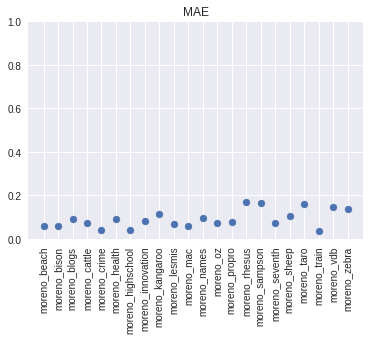

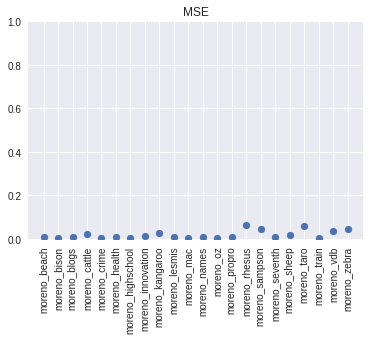

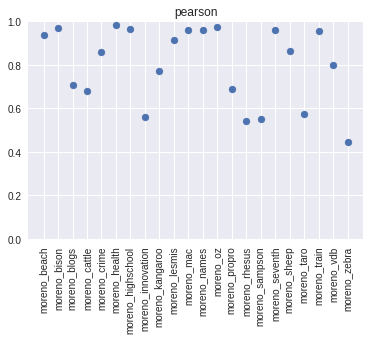

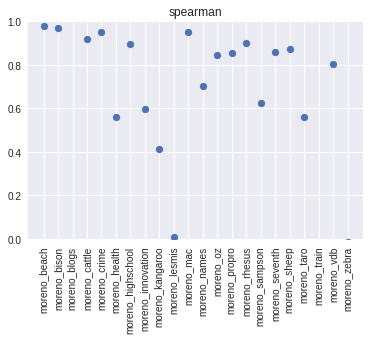

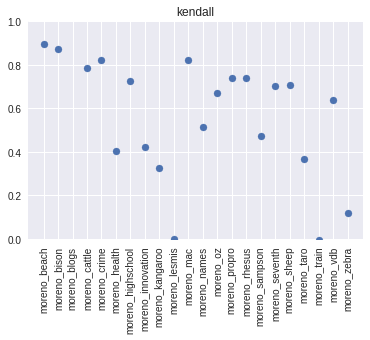

In [136]:
for error_type in real_prediction_results['error_type'].unique():
    x=real_prediction_results[real_prediction_results['error_type']==error_type]['network']
    y=real_prediction_results[real_prediction_results['error_type']==error_type]['error_value']
    
    plt.title(error_type)
    plt.xticks(rotation='vertical')
    plt.ylim([0,1])
    plt.scatter(x=x, y=y)
    plt.show()

### Fourth experiment: Transfer learning

In [137]:


real_data_measures=pd.read_pickle('./real_networks_calulated_betweenness_and_energy.pickle')

transfer_real_prediction_results=pd.DataFrame(columns=['network', 'error_type', 'error_value', 'source_network'])

raw_results=pd.DataFrame(columns=['network', 'source_network', 'y', 'y_pred'])


for i in tqdm(range(len(models))):
    for net in (real_data_measures['network'].unique()):
        y=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='betweenness')
                 ]['value'].values

        X=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='graph')
                 ]['value'].values
        
        y_pred=models[i].predict(X.reshape(-1, 1))
        
        eval_res=evaluate_results(net,y,y_pred)
        eval_res['source_network']=networks_names[i]
        
        raw_results=pd.concat([raw_results, pd.DataFrame.from_dict({'network': net, 'source_network': networks_names[i], 'y': y, 'y_pred':y_pred})])
        
        transfer_real_prediction_results=pd.concat([transfer_real_prediction_results,eval_res])

100%|██████████| 22/22 [00:12<00:00,  1.72it/s]


lets draw heatmap

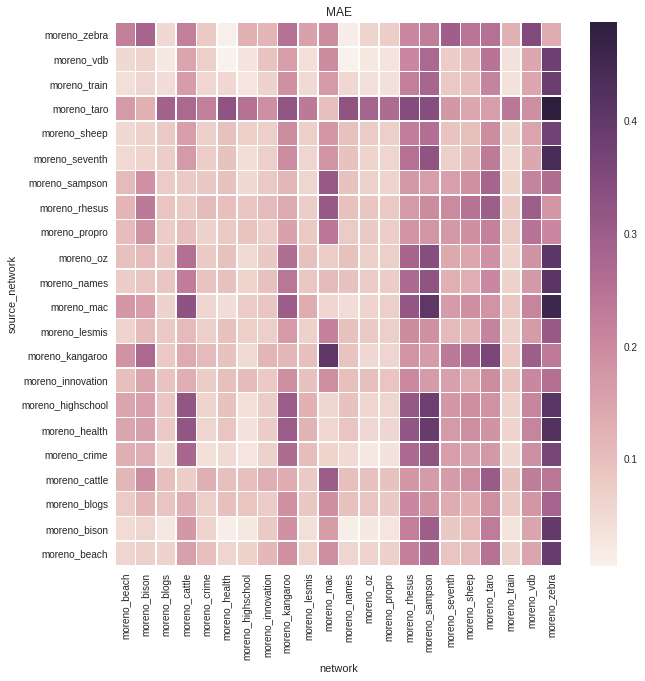

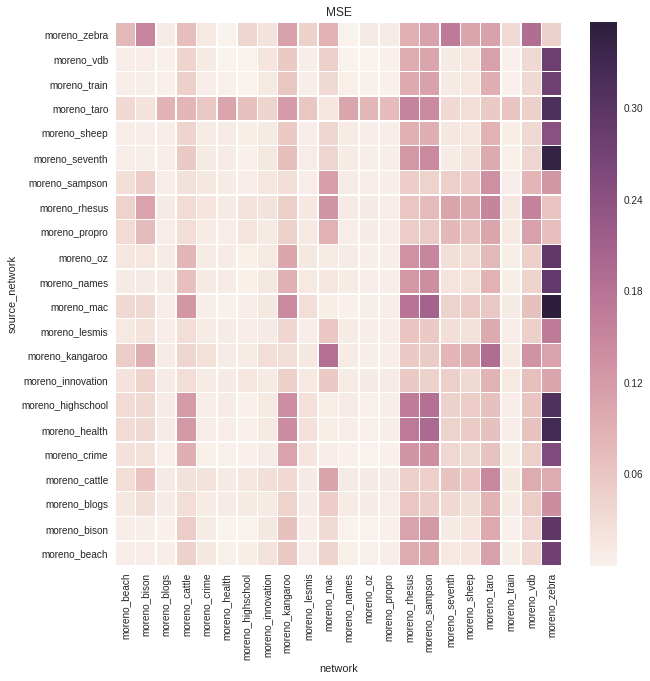

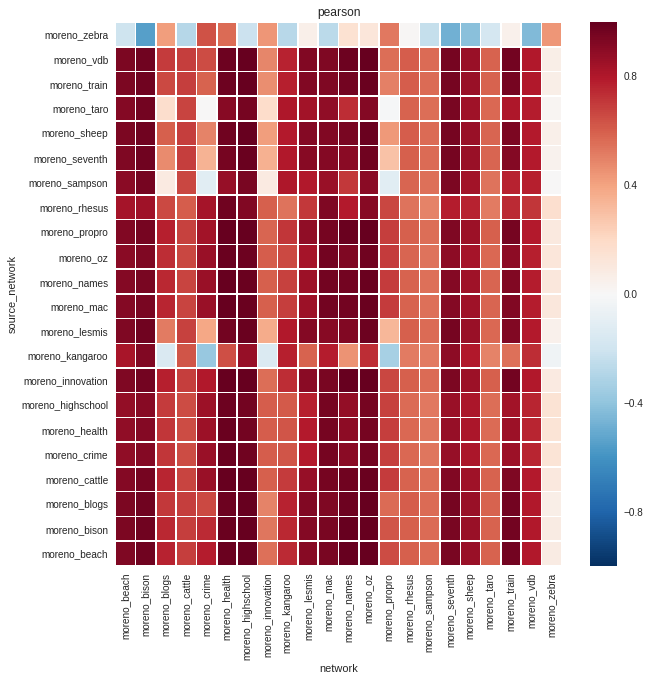

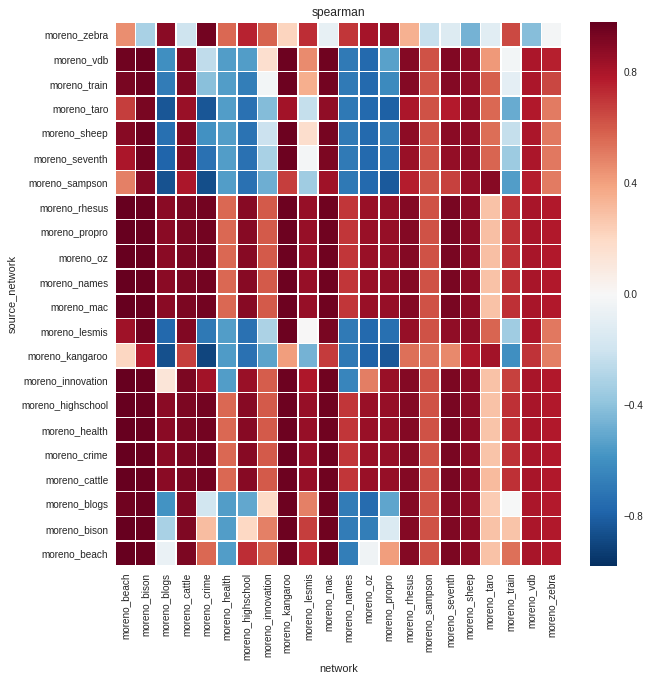

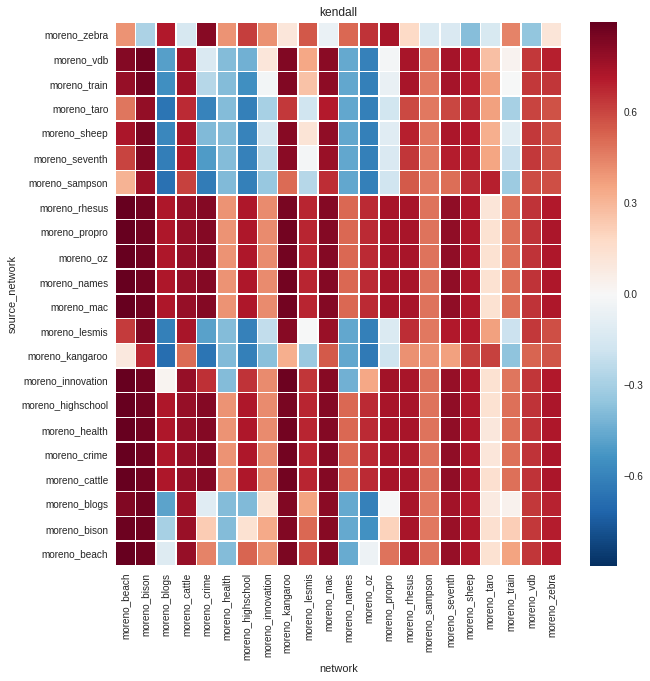

In [147]:
for error_type in transfer_real_prediction_results['error_type'].unique():
    x=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['network'].unique()
    y=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['network'].unique()
    val=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['error_value']
#     print(val)
    val=np.array(val)
    val=val.reshape(len(x),len(y))
#     print(val)
    
#     plt.title(error_type)
#     plt.xticks(rotation='vertical')
#     plt.ylabel(y)
#     plt.imshow(val, cmap='hot', interpolation='nearest')
    

    plt.figure(figsize=(10,10))
    plt.title(error_type)
    
    to_draw=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]
#     print(to_draw)
    ax = sns.heatmap(to_draw[['error_value', 'source_network', 'network']].pivot('source_network','network','error_value'), linewidth=0.5)
    ax.invert_yaxis()
    plt.show()
    

In [336]:
results_networks=pd.DataFrame(columns=['betweeness', 'randic', 'graph','network', 'param', 'time_randic','time_graph','time_betweeness'])

for i in tqdm(range(len(networks))):
    network=networks[i]
    start = time.clock()
    bet=calculate_betweenes(network)
    bet_time=time.clock() - start
    
    start = time.clock()
    re=calculate_randic_energy(network)
    re_time=time.clock() - start
    
    start = time.clock()
    ge=calculate_graph_energy(network)
    ge_time=time.clock() - start
    
    betre = {key:[bet[key], re[key], ge[key]] for key in bet}

    betredf=pd.DataFrame({'betweeness':[i[0] for i in betre.values()],
                          'randic':[i[1] for i in betre.values()],
                          'graph':[i[2] for i in betre.values()]})
    betredf['network']=networks_names[i]
    betredf['param']=None
    betredf['time_randic']=re_time
    betredf['time_betweeness']=bet_time
    betredf['time_graph']=ge_time
    results_networks=pd.concat([results_networks,betredf])

100%|██████████| 23/23 [04:55<00:00, 12.86s/it]


In [377]:
for network_result in results_networks.network.unique():
    sns.plt.title(network_result)
    sns.jointplot("betweeness", "randic", data=results_networks[results_networks['network']==network_result], kind="reg", color="r", size=8)
    
    sns.plt.title(network_result)
    sns.jointplot("betweeness", "graph", data=results_networks[results_networks['network']==network_result], kind="reg", color="b", size=8)
    

NameError: name 'results_networks' is not defined

#### Summary: 
- all (obviously with some variance) networks have high correlations between Randić energy of ego networks and betweeness

### Fifth experiment: computation time comparison (real-word data)

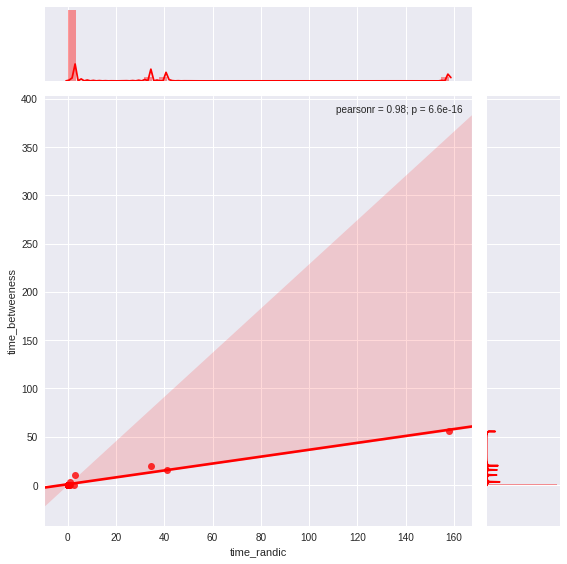

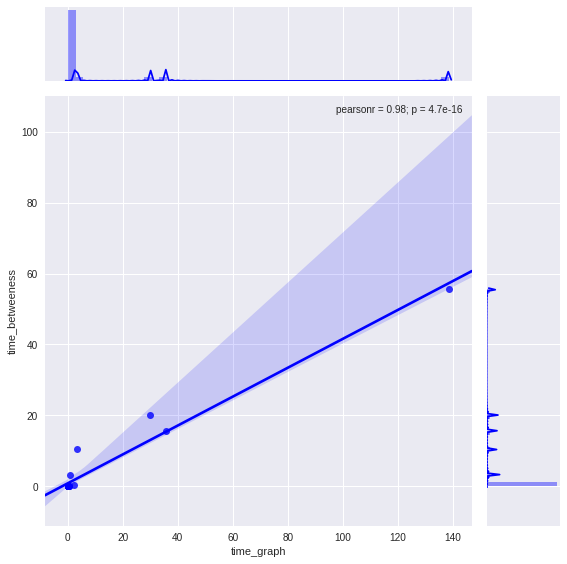

In [339]:
results_networks.groupby(by='network').mean()
sns.jointplot("time_randic", "time_betweeness", data=results_networks.groupby(by='network').mean(), kind="reg", color="r", size=8)

sns.jointplot("time_graph", "time_betweeness", data=results_networks.groupby(by='network').mean(), kind="reg", color="b", size=8)

#### Summary: 
- calculation of Randić energy of ego networks takes ~2 time the betweeness take :(
- the need to check the way in which egocentric networks are obtained and the energy is calculated

### Available datasets from KONECT

In [322]:
read_avalilable_datasets_konect()


['actor-collaboration',
 'actor-movie',
 'adjnoun_adjacency',
 'advogato',
 'amazon0601',
 'amazon-ratings',
 'arenas-email',
 'arenas-jazz',
 'arenas-meta',
 'arenas-pgp',
 'as20000102',
 'as-caida20071105',
 'as-skitter',
 'bibsonomy-2ti',
 'bibsonomy-2ui',
 'bibsonomy-2ut',
 'bookcrossing_full-rating',
 'bookcrossing_rating',
 'brunson_club-membership',
 'brunson_southern-women',
 'brunson_corporate-leadership',
 'brunson_revolution',
 'brunson_south-africa',
 'ca-AstroPh',
 'ca-cit-HepPh',
 'ca-cit-HepTh',
 'chess',
 'cfinder-google',
 'citeseer',
 'citeulike-ti',
 'citeulike-ui',
 'citeulike-ut',
 'cit-HepPh',
 'cit-HepTh',
 'com-amazon',
 'com-dblp',
 'com-youtube',
 'contact',
 'contiguous-usa',
 'dblp-author',
 'dblp-cite',
 'dblp_coauthor',
 'dbpedia-all',
 'dbpedia-country',
 'dbpedia-genre',
 'dbpedia-link',
 'dbpedia-location',
 'dbpedia-occupation',
 'dbpedia-producer',
 'dbpedia-recordlabel',
 'dbpedia-starring',
 'dbpedia-team',
 'dbpedia-writer',
 'dbtropes-feature',
 '

### Further experimental scenario:
1. Analitical comparison of computational complexity (Randić ego-nets vs betweeness)
2. Accuracy of betweeness estimation based on Randić ego-nets:
    1. Get real-world networks
    2. Calculate node betweeness
    3. Calculate node Randic energy
    4. Build CV and test with norm-2 error

# Plan eksperymentu (PL)
- wyliczenie dla wszystkich wierzchołków sieci ich pośrednictwa, pośrednictwa szacowanego na podstawie ścieżek o długości 2, 3, ..., k, oraz energii macierzy sąsiedztwa w sieci egocentrycznej
- wyznaczenie prostej regresji liniowej m/y pośrednictwem i energią wierzchołka, miarami jakości mogą być:
  * korelacja Pearsona
  * korelacja Spearmana
  * korelacja Kendalla
  * błąd bezwzględny (po normalizacji obu miar)
  * błąd średniokwadratowy (po normalizacji obu miar)
- do porównania bierzemy wynik na podstawie energii i porównujemy z wynikiem na podstawie estymacji pośrednictwa
- zamiast prostej regresji możemy nauczyć model, korzystając z następujących cech:
  * energia macierzy sąsiedztwa sieci egocentrycznej wierzchołka
  * min/avg/max energii macierzy sąsiedztwa sąsiadów wierzchołka

- jako dodatkowy bonus możemy pokazać, że w przypadku energii następuje transfer learning, tzn. możemy nauczyć model raz na jednej instancji sieci i wyznaczyć jego dokładność dla całego zbioru sieci po podobnej topologii, ale nieco innych parametrach (zakładając, że wierzchołki nie mają tożsamości, nie da się takiego transferu przeprowadzić innymi metodami)